## MTC evaluation - part 1

This serves as a baseline, for better understanding of MTC's functioning.

### Summary

- First initialization  

- Preliminary assessment: 
    - parameter tuning, with k-fold cross validation
    - comparison across *predict* methods 

### Main takeaways

MTClassifier displayed satisfying results against rather challenging synthetic data.

Parameter tuning highlighted that:
   - when it comes to number of partitions and maximum tree depth: the higher the value of the parameter, the better the MCC score; 
   - the number of minimum instances required in a node does not significantly affect the classifier's performance;
   - manhattan distance function is featured in the instance with the absolute best MCC - however, euclidean performs better overall;
   - MTClustT instances allow for better performance than MTClust;
    
Hence, from now on MTC will be initialized with:
 - *n_parts* = 10
 - *max_depth* = 20
 - *min_instances* = 5
 - *use_binary_class* = True 
 - *dist_func* = euclidean
  
Given that:
   - *predict*, *predict_abs*, and *predict_basic* display very similar performances (all MCCs around 0.8)
   - the other models we will use for comparison feature a *predict* method, as it is part of scikit-learn's default implementation
     
we will carry on with the analysis using MTC's *predict* for predictions.


In [3]:
from MTC2 import MTClust, MTClustT, MTClassifier

# 0. First initialization

Tried an instance of MTC on a **synthetic dataset**, generated with the *make_classification* function 
from scikit-learn.  

MTC is initialized with random parameters.
  
Results:
- MCC = 0.58;
- CKS = 0.53.  

In [4]:
#import libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, sample, seed

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler


In [5]:
#create dataset 
X0, y0 = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=2,
    n_redundant=2,
    
    n_classes=2,
    n_clusters_per_class=1,
    weights=[0.3,0.7],
    flip_y=0.02,
    class_sep=0.5,
    
    random_state=42)

#train/test split
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=42)

On the dataset: parameters values such as:
- ratio of meaningful features of 0.2
- classes weights of 0.3 and 0.7
- class separability index of 0.5 (low, default value is 1.0)

are meant to recreate a real-world scenario.

In [6]:
#initialize MTC and train to training test
seed(6)
mtc = MTClassifier(n_parts=10, max_depth=20, min_instances=5, use_binary_class=True, dist_func="euclidean")

mtc.fit(X0_train, y0_train)

Binary classification


In [7]:
#predict
y0_pred = mtc.predict(X0_test)

#compute MCC and CKS
MCC = matthews_corrcoef(y0_test, y0_pred)
print("MCC: {:.3f}".format(MCC))
      
kappa_score = cohen_kappa_score(y0_test, y0_pred)
print("Cohen's Kappa Score: {:.3f}".format(kappa_score))

MCC: 0.529
Cohen's Kappa Score: 0.475


In [9]:
print("Confusion Matrix:")
print(confusion_matrix(y0_test, y0_pred))

Confusion Matrix:
[[ 268  355]
 [  31 1346]]


# 1. Preliminary assessment

## 1.1 Parameter tuning

**!**: Tried GridSearchCV: doesn't work because there's no *get_params* method in MTClassifier (more in the report).  
  
Again, performed on synthetic data, duly scaled with *StandardScaler*.
1. **Grid** is created to store parameters to be tried
    - dictionary (parameters are keys, parameter values are values)
    - this allows in a number of parameter combinations for MTC to be initialized with   
2. **K-fold cross-validation** is set up  
3. For each parameter combination:
    - MTC is run *k* times
    - **Average MCC** across the *k* folds is computed
    - and stored in a Pandas dataframe     
4. Eventually, combination with **best** average **MCC** is **retrieved** 
5. **Results** are **visualized**
    - Distributions of MCC scores
        - absolute
        - by parameter
    - Heatmaps  
    - Pairplots   

In [10]:
#create dataset
seed(10)
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=5,
    n_redundant=2,
    
    n_classes=2,
    n_clusters_per_class=1,
    weights=[0.33,0.67],
    flip_y=0.02,
    class_sep=0.65,
    
    random_state=42)

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#data scaling
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#create parameters grid
parameter_grid = {
    'n_parts': [3, 5, 10],
    'max_depth': [5, 10, 20], 
    'min_instances': [5, 15, 25], 
    'use_binary_class': [True, False],
    'dist_func': ['euclidean', 'manhattan', 'jaccard']
}

In [12]:
#create Pandas dataframe to store results for each parameter combination
results_df = pd.DataFrame(columns=['n_parts', 'max_depth', 'min_instances', 
                                   'use_binary_class', 'dist_func', 'MCC'])

#kfold setup 
n_folds = 4
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

best_params = None
best_MCC = 0

from itertools import product

#create parameter dictionary from grid
for params in product(*parameter_grid.values()):
    param_dict = dict(zip(parameter_grid.keys(), params))
    print("Trying parameters:", param_dict)

    #initializing cumulative MCC score for current parameter combination
    cumulative_MCC = 0

    #iterating over k folds
    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        #initialize MTC and train on train fold
        seed(11)
        mtcPT = MTClassifier(**param_dict)
        mtcPT.fit(X_train_fold, y_train_fold)

        #predict on validation fold, compute MCC
        y_pred_fold = mtcPT.predict(X_val_fold)
        cumulative_MCC += matthews_corrcoef(y_val_fold, y_pred_fold)
    
          
    #calculate average MCC for current parameter combination
    average_MCC = cumulative_MCC / n_folds
    print("Average MCC:", average_MCC)

     #store results in the Pandas dataframe
    param_dict['MCC'] = average_MCC
    results_df = pd.concat([results_df, pd.DataFrame([param_dict])], ignore_index=True)
     
    #if current model is better, update best parameters
    if average_MCC > best_MCC:
        best_MCC = average_MCC
        best_params = param_dict

print("Best Parameters:", best_params)
print("Best Average MCC:", best_MCC)


Trying parameters: {'n_parts': 3, 'max_depth': 5, 'min_instances': 5, 'use_binary_class': True, 'dist_func': 'euclidean'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.4958379593323195
Trying parameters: {'n_parts': 3, 'max_depth': 5, 'min_instances': 5, 'use_binary_class': True, 'dist_func': 'manhattan'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.48418608162476007
Trying parameters: {'n_parts': 3, 'max_depth': 5, 'min_instances': 5, 'use_binary_class': True, 'dist_func': 'jaccard'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.13867242220420545
Trying parameters: {'n_parts': 3, 'max_depth': 5, 'min_instances': 5, 'use_binary_class': False, 'dist_func': 'euclidean'}
Average MCC: 0.4226644553816896
Trying parameters: {'n_parts': 3, 'max_depth': 5, 'min_instances': 5, 'use_binary_class': False, 'dist_func': 'manhatta

Average MCC: 0.3089746577305885
Trying parameters: {'n_parts': 3, 'max_depth': 20, 'min_instances': 15, 'use_binary_class': True, 'dist_func': 'euclidean'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.5971923830711663
Trying parameters: {'n_parts': 3, 'max_depth': 20, 'min_instances': 15, 'use_binary_class': True, 'dist_func': 'manhattan'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.6061239541474245
Trying parameters: {'n_parts': 3, 'max_depth': 20, 'min_instances': 15, 'use_binary_class': True, 'dist_func': 'jaccard'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.3906393153378553
Trying parameters: {'n_parts': 3, 'max_depth': 20, 'min_instances': 15, 'use_binary_class': False, 'dist_func': 'euclidean'}
Average MCC: 0.5465036481064026
Trying parameters: {'n_parts': 3, 'max_depth': 20, 'min_instances': 15, 'use_bina

Average MCC: 0.543242680131962
Trying parameters: {'n_parts': 5, 'max_depth': 10, 'min_instances': 15, 'use_binary_class': False, 'dist_func': 'jaccard'}
Average MCC: 0.19088704828068342
Trying parameters: {'n_parts': 5, 'max_depth': 10, 'min_instances': 25, 'use_binary_class': True, 'dist_func': 'euclidean'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.6189797427250516
Trying parameters: {'n_parts': 5, 'max_depth': 10, 'min_instances': 25, 'use_binary_class': True, 'dist_func': 'manhattan'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.6254891915933101
Trying parameters: {'n_parts': 5, 'max_depth': 10, 'min_instances': 25, 'use_binary_class': True, 'dist_func': 'jaccard'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.266766392042765
Trying parameters: {'n_parts': 5, 'max_depth': 10, 'min_instances': 25, 'use_binary_

Average MCC: 0.4692417306870227
Trying parameters: {'n_parts': 10, 'max_depth': 5, 'min_instances': 25, 'use_binary_class': False, 'dist_func': 'manhattan'}
Average MCC: 0.4583866201621854
Trying parameters: {'n_parts': 10, 'max_depth': 5, 'min_instances': 25, 'use_binary_class': False, 'dist_func': 'jaccard'}
Average MCC: 0.02914655594067692
Trying parameters: {'n_parts': 10, 'max_depth': 10, 'min_instances': 5, 'use_binary_class': True, 'dist_func': 'euclidean'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.6484379037116053
Trying parameters: {'n_parts': 10, 'max_depth': 10, 'min_instances': 5, 'use_binary_class': True, 'dist_func': 'manhattan'}
Binary classification
Binary classification
Binary classification
Binary classification
Average MCC: 0.6612804656952603
Trying parameters: {'n_parts': 10, 'max_depth': 10, 'min_instances': 5, 'use_binary_class': True, 'dist_func': 'jaccard'}
Binary classification
Binary classification
B

**Best parameter combination** is:

- *n_parts* = 10
- *max_depth* = 20
- *min_instances* = 5
- *use_binary_class* = True 
- *dist_func* = manhattan

Average **MCC** associated: **0.69**


## 1.2 Visualizing results

### Overall

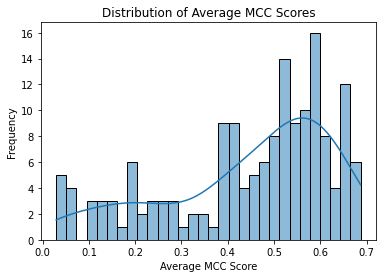

In [31]:
#distribution of MCC scores
sns.histplot(data=results_df, x='MCC', bins=30, kde=True)

plt.title('Distribution of Average MCC Scores')
plt.xlabel('Average MCC Score')
plt.ylabel('Frequency')

plt.show()

### Number of partitions, maximum depth

We can see that:
- the greater the number of partitions
- the higher the maximum depth of the tree

the higher the MCC.

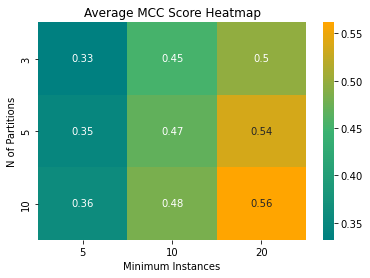

In [66]:
#heatmap for minimum instances over number of partitions
import matplotlib.colors as mcolors

colors = ["teal", "mediumseagreen", "orange"]
cmap_name = "custom_diverging"
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

pivot_table = results_df.pivot_table(values='MCC', index='n_parts', columns='max_depth', aggfunc='mean')

sns.heatmap(pivot_table, annot=True, cmap=cm)
plt.title('Average MCC Score Heatmap')
plt.xlabel('Minimum Instances')
plt.ylabel('N of Partitions')

plt.show()

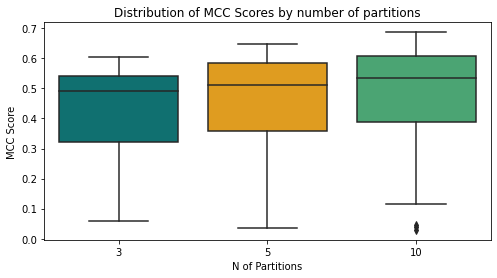

In [51]:
#boxplots by number of partitions

plt.figure(figsize=(8, 4))
sns.boxplot(x='n_parts', y='MCC', data=results_df, palette=['teal','orange','mediumseagreen'])

plt.title('Distribution of MCC Scores by number of partitions')
plt.xlabel('N of Partitions')
plt.ylabel('MCC Score')

plt.show()

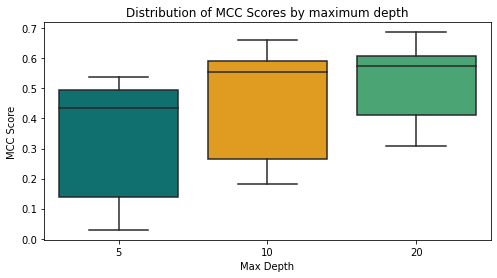

In [50]:
#boxplots by maximum depth

plt.figure(figsize=(8, 4)) 
sns.boxplot(x='max_depth', y='MCC', data=results_df, palette=['teal','orange','mediumseagreen'])

plt.title('Distribution of MCC Scores by maximum depth')
plt.xlabel('Max Depth')
plt.ylabel('MCC Score')

plt.show()

### Minimum instances

On the other hand, the number of minimum instances required in a node doesn't seem to significantly influence the MCC.

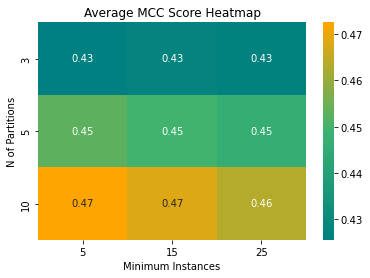

In [67]:
#heatmap for minimum instances over number of partitions
import matplotlib.colors as mcolors

colors = ["teal", "mediumseagreen", "orange"]
cmap_name = "custom_diverging"
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

pivot_table = results_df.pivot_table(values='MCC', index='n_parts', columns='min_instances', aggfunc='mean')

sns.heatmap(pivot_table, annot=True, cmap=cm)
plt.title('Average MCC Score Heatmap')
plt.xlabel('Minimum Instances')
plt.ylabel('N of Partitions')

plt.show()

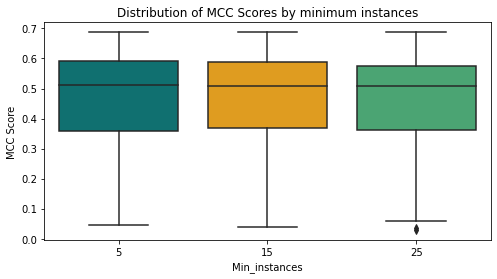

In [52]:
#boxplots by minimum instances

plt.figure(figsize=(8, 4)) 
sns.boxplot(x='min_instances', y='MCC', data=results_df, palette=['teal','orange','mediumseagreen'])

plt.title('Distribution of MCC Scores by minimum instances')
plt.xlabel('Min_instances')
plt.ylabel('MCC Score')

plt.show()

### Distance function

Best are manhattan and euclidean.

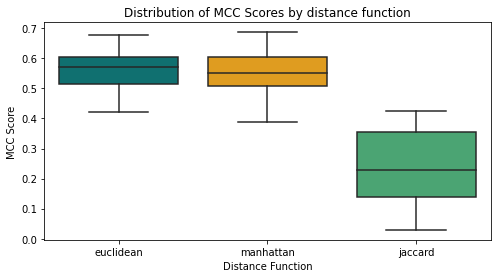

In [53]:
#boxplots by distance function

plt.figure(figsize=(8, 4)) 
sns.boxplot(x='dist_func', y='MCC', data=results_df, palette=['teal','orange','mediumseagreen'])

plt.title('Distribution of MCC Scores by distance function')
plt.xlabel('Distance Function')
plt.ylabel('MCC Score')

plt.show()

### MTClust vs MTClustT

The pairplot shows how results for instances of the target-oriented classifier are consistently better. 

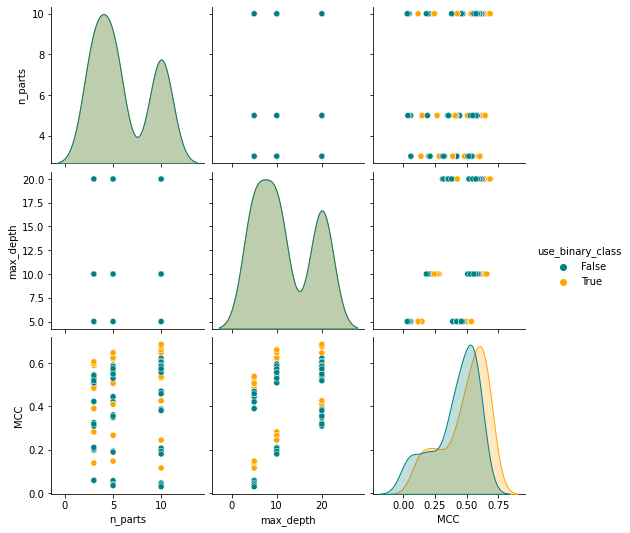

In [47]:
#pairplot for binary_class
sns.pairplot(data=results_df, vars=['n_parts', 'max_depth', 'MCC'], hue='use_binary_class', palette=['teal','orange'])

plt.show()

## 1.3 *Predict* methods comparison

MTClassifier features **four different methods** for prediction (see *MTC_code_descr*).

However, **MCCs** for predictions resulting from the different methods are **not significantly different**. 
  
For this reason, we decided to carry on with the analysis implementing the *predict* method, as it is the one used by the machine learning algorithm we are going to evaluate MTClassifier against. 

In [26]:
#create dataset
seed(10)
X_pm, y_pm = make_classification(
    n_samples=30000,
    n_features=20,
    n_informative=4,
    
    n_classes=2,
    n_clusters_per_class=1,
    weights=[0.3, 0.7], 
    class_sep=0.6, 
    
    random_state=42)

#train/test split
X_train_pm, X_test_pm, y_train_pm, y_test_pm = train_test_split(X_pm, y_pm, test_size=0.2, random_state=42)


#initialize MTC with best parameters, then fit
mtc = MTClassifier(n_parts=10, max_depth=20, min_instances=5, use_binary_class=True, dist_func='euclidean')
mtc.fit(X_train_pm, y_train_pm, verbose=True)

Binary classification
  1 partition
  2 partition
  3 partition
  4 partition
  5 partition
  6 partition
  7 partition
  8 partition
  9 partition
 10 partition


In [27]:
#predicting with MTC's different prediction methods 
y_pred_basic = mtc.predict_basic(X_test_pm)
mcc_basic = matthews_corrcoef(y_test_pm, y_pred_basic)
print(f"MCC using predict_basic: {mcc_basic*100:.2f}%")

y_pred_abs = mtc.predict_abs(X_test_pm)
mcc_abs = matthews_corrcoef(y_test_pm, y_pred_abs)
print(f"MCC using predict_abs: {mcc_abs*100:.2f}%")

y_pred = mtc.predict(X_test_pm)
mcc = matthews_corrcoef(y_test_pm, y_pred)
print(f"MCC using predict: {mcc*100:.2f}%")

MCC using predict_basic: 67.80%
MCC using predict_abs: 67.87%
MCC using predict: 67.92%


In [28]:
y_pred_proba = mtc.predict_proba(X_test_pm)

for i, probs in enumerate(y_pred_proba[:5]):
    print(f"Probabilities for test sample {i+1}: {probs}")

Probabilities for test sample 1: [1.14360308e-10 1.00000000e+00]
Probabilities for test sample 2: [2.44315945e-17 1.00000000e+00]
Probabilities for test sample 3: [5.19773985e-17 1.00000000e+00]
Probabilities for test sample 4: [1.00000000e+00 2.20277362e-11]
Probabilities for test sample 5: [2.35899576e-10 1.00000000e+00]


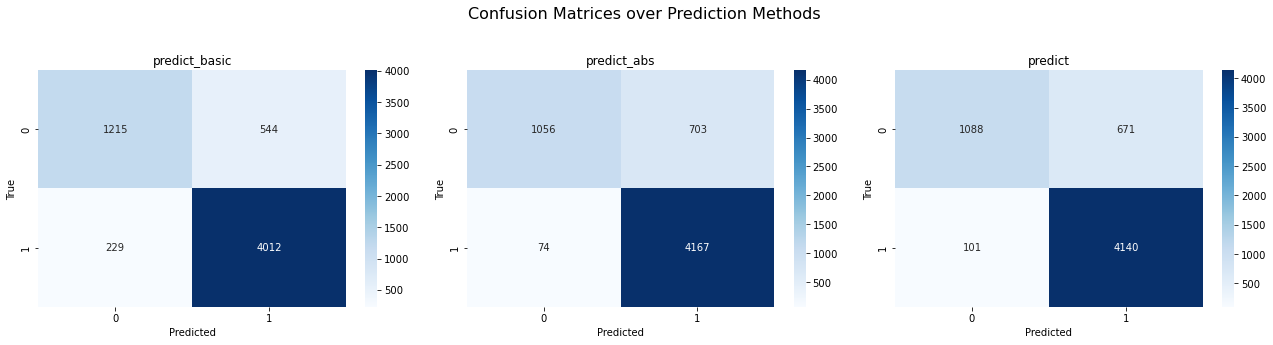

In [29]:
#check for datatype of inputs
y_pred_basic = np.array(y_pred_basic).astype(int)
y_pred_abs = np.array(y_pred_abs).astype(int)
y_pred = np.array(y_pred).astype(int)

#create confusion matrices for each prediction method
cm_basic = confusion_matrix(y_test_pm, y_pred_basic)
cm_abs = confusion_matrix(y_test_pm, y_pred_abs)
cm = confusion_matrix(y_test_pm, y_pred)


#plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices over Prediction Methods', fontsize=16)


sns.heatmap(cm_basic, annot=True, fmt='g', ax=axs[0], cmap='Blues')
axs[0].set_title('predict_basic')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_abs, annot=True, fmt='g', ax=axs[1], cmap='Blues')
axs[1].set_title('predict_abs')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

sns.heatmap(cm, annot=True, fmt='g', ax=axs[2], cmap='Blues')
axs[2].set_title('predict')
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('True')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()